# CS 224, Fall 2021
## Problem Set E2

## **DUE SUNDAY, December 5, 2021 @ 11:59pm PDT **
## THIS IS A COMPLETELY OPTIONAL PROBLEM SET

Not completing this problem set will not affect your grade.  Put differently, if others complete the problem set, that will *not* lower your grade.  This course is not graded in a relative fashion.

<div class="alert alert-info">
    <b>Complete with your Information</b><br>
    <i>By Submitting this notebook, I assert that all of the work presented here is my own and performed for the express sole purpose of this offering of this course.</i><br>
        <br>
      <b>(full) Name:</b>  Your Name Here  <br>
    <b>Student ID Number:</b> Your SIN Here
</div>

<div class="alert alert-success">
    <font size=+2>Total Problem Set Grading</font> (to be completed by grader)<br>
    Total Points: /8<br>
    Late Days Used on this Assignment: <br>
    Total Late Days Used: <br>
</div>

## Preliminaries
### (the data are just as with PS 2, except that we are only doing classification, so trainY and testY are both the binary values)

We will again be using the data shown in class on house sales in Ames, Iowa.  Data documentation can be found at http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

The code block below again loads in the data.  However, this time we will be using a one-hot encoding of the categorical features (see code comments). 

**Do NOT adjust** this code.  Further, you **may not add additional imports** to this notebook.

The resulting variables are slightly different than last time:
 - `trainX` & `trainY`: the training data, `trainX` has shape (number of homes, number of features) and `trainY` has shape (number of homes,).  We are trying to predict the y-values (whether the sales price is greater than 200K) from the x-values (other features of the homes for sale).
 - `subtrainX` & `subtrainY` are the parts of the training set not used for validation and `validX` and `validY` are the validation set
 - `testX` & `testY`: the testing data, in the same format at the training data.  We will use this as independent testing samples to see how well the training worked.
 - `featurenames`: an array (of strings) of each of the features'/columns' names
 - `nfeat`: total number of features/columns

In [103]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100 # this and above will make the figures large enough to read
def loadamesdata(trainfrac = 0.5):
    import pandas as pd
    from IPython.display import display
    
    dataframe = pd.read_table('AmesHousing.txt',delimiter='\t')

    dataframe = dataframe[dataframe['Gr Liv Area']<4000] # remove the five really large houses
    dataframe = dataframe[dataframe['Sale Condition']=='Normal'] # don't consider partial sales or other types of abnormal sales
    dataframe = dataframe.drop(columns=['Order','PID','Sale Condition','Low Qual Fin SF','Pool Area','Pool QC'])
    
    categoricalf = [col for col in dataframe if dataframe[col].dtype.name=='object' or col=='MS SubClass']
     # Here we are encoding the categorical variables using a "one-hot" encoding.  A variable with 3 values (A, B, C)
    # gets converted into three binary variables.  For any example (row) exactly one of these binary variables is 1
    # indicating which value the original categorical variable took on.
    dataframe = pd.get_dummies(dataframe,columns=categoricalf,prefix=categoricalf,dummy_na=True)
    # Here we are going to remove any item that is missing a value (encoded as NaN at this stage)
    # This is slightly problematic (it could be the missingness is actually related to the value or other features' values)
    # Filling it in (with say the average for that feature) is also problematic, in different ways
    # So for this problem set, we'll just remove listings (rows) that are missing any of their non-categorical features
    dataframe.dropna(inplace=True) # 
    
    dataframe = dataframe.loc[:,(dataframe!=dataframe.iloc[0]).any()] # drop features that have all the same value (across both training and testing)
    
    dataframe['SalePrice'] = dataframe['SalePrice']/1000 # convert to thousands of dollars, to prevent lots of extra 0s from needing to be printed
    dataframe = dataframe[[c for c in dataframe if c != 'SalePrice']+['SalePrice']]# rearrange to put SalePrice at the end:
    # training/testing split
    # can use "from sklearn.model_selection import train_test_split"
    # but to more directly show what is going on, here is a more "raw" version:
    allXY = dataframe.to_numpy()
    

    allXY = allXY[np.isfinite(allXY).all(axis=1),:]
    
    # in general, we would take a random shuffle.  However, to grade this consistently, I am going to fix the randomness of the shuffle
    np.random.seed(829281934) # my favorite number (well, out of the natural numbers) ;)
    np.random.shuffle(allXY) # randomly shuffles the *rows* of the input (or along whatever is the first dimension of the tensor)
    # we'll pick the first 50% (as default -- see "trainfrac" parameter as training and save the last 50% for testing
    lasttraini = int(allXY.shape[0]*trainfrac)
    trainXY = allXY[:lasttraini,:]
    testXY = allXY[lasttraini:,:]
    
    trainX = trainXY[:,:-1]
    trainY = trainXY[:,-1]
    testX = testXY[:,:-1]
    testY = testXY[:,-1]

    return trainX,trainY,testX,testY, dataframe.columns

trainX,trainY,testX,testY,featurenames = loadamesdata(0.7)
nfeat = trainX.shape[1]
binaryclassthreshold = 200
trainY = (trainY>binaryclassthreshold).astype(int)
testY = (testY>binaryclassthreshold).astype(int)


# split training further into training (called "subtrain") and validation
spliti = int(trainX.shape[0]*0.7)
subtrainX = trainX[:spliti,:]
subtrainY = trainY[:spliti]
validX = trainX[spliti:,:]
validY = trainY[spliti:]

### Data Normalization

First, we are going to "standardize" or "normalize" each input feature.  Consider that the square footage for living area is not really 
comparable with the year built or the number of kitchens.  To put these different features "on the same scale," we will divide each by
its standard deviation.

There is no principled reason to expect this to have a useful effect.  However, in practice, this works very well as an initial normalizing
step and is fairly universal.

After you have completed the assignment, you may try commenting out the code below and rerunning to see the difference.  It is instructive.  However, please
submit with this code block active.

In [104]:
stddevs = np.std(trainX,axis=0)+1e-6
means = np.mean(trainX,axis=0)
trainX = (trainX-means)/stddevs
subtrainX = (subtrainX-means)/stddevs
validX = (validX-means)/stddevs
testX = (testX-means)/stddevs

<div class="alert alert-warning">
    <font size=+2>Question 1</font><br>
    <font size=+1>5 points</font>
</div>

<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: /5<br>
</div>

Complete the function below, learnlr.  It should use gradient descent to learn the weights for logistic regression.  It should return
a weight vector that is one size larger than the number of features in X, with the extra weight (at the end of the vector) being the offset
value.

For a good starting point, use the answer from linear least squares (if you treat Y as +1/-1; note that the matrix provided is 1/0).

To get quick(ish) convergence without too much fiddling, implement the following method for selecting the step-size, $\eta$:
 - Start $\eta$ at 1.0
 - If any step of gradient descent does not improve the loss function by at least $10^{-6}$:
   - undo the step
   - multiply $\eta$ by 0.9
   - continue with gradient descent
 - Stop when $\eta$ is less than $10^{-6}$
You may get one or two overflow warnings on some inputs when the eta is large.  This is fine.  Your code will step down to a smaller eta and
proceed without a problem.
 
Your method will also need to support $\ell_2$ regularization.  The strength of which is specified by the parameter `lam`.

The form of the loss, therefore, should be

$$L = \left(\sum_{i=1}^m \ln\left(1+e^{-y_ix^T_i w}\right)\right) + \lambda\sum_{j=1}^n w_j^2$$

(where $n$ is the number of features, including the added feature of $1$s).

*note: for this question, 1 of the 5 points is for code readability (but can only be obtained if the code is correct or close to being correct)*

In [105]:
print(trainX.shape)
print(trainY.shape)
print(featurenames.shape)


(1292, 296)
(1292,)
(297,)


In [106]:
# # a helper function to add a column of 1s to a matrix
# def addones(X):
#     return np.append(X,np.ones((X.shape[0],1)),axis=1)

# def sigmoid(z):
#     return 1/(1+np.exp(-z))

# def ridgeregression(X,Y,lam):
#     if lam==0.0:
#         w = np.linalg.pinv(X)@Y
#     else:
#         myeye = np.eye(X.shape[1])
#         myeye[-1,-1] = 0
#         w = np.linalg.solve(X.T@X+lam*myeye,X.T@Y)
#     return w
    
# def rrclass(X,Y,lam=0.0):
#     w = ridgeregression(addones(trainX),Y,lam)
#     w[-1] -= binaryclassthreshold
#     return w
    
# def gd(y_hat, w):
#     pass
    

# def learnlr(X,Y,lam=0.0):
#     # X is an m-by-n matrix
#     # Y is an m dimensional vector of 0s and 1s
#     # lam is the regularization strength (scalar)
#     # should return an (n+1) dimensional vector of weights
    
#     ## Your code here
#     newtrainX = addones(X)
#     Y = np.where(Y>0,1,-1)
#     w = ridgeregression(newtrainX,Y,0.0)
#     # w = np.linalg.pinv(newtrainX)@Y
#     prev_loss  = np.sum(np.log(1+np.exp(-newtrainX@w*Y) ))
#     # prev_loss  = np.sum(np.log(1+np.exp((-newtrainX.T*Y).T@w) ))
#     eta = 1.0
#     # w[-1] -= binaryclassthreshold
#     # print(w.shape)
#     # f = newtrainX@w
#     # y_hat = np.where(f>0,1,-1)

#     # prev_loss=0.0
#     # for i in range(newtrainX.shape[1]):
#     #     prev_loss += lam*(w[i]*w[i])
#     # for i in range(newtrainX.shape[0]):
#     #     prev_loss += np.sum(np.log(1+np.exp(-(Y[i]@newtrainX[i]@w))))
    
#     while eta >= 0.000001:
#         # dL = (1-np.sum(sigmoid((newtrainX@w)*Y)))*(newtrainX.T@Y)
#         dL=0.0
#         for i in range(newtrainX.shape[0]):
#             dL+= -(1-sigmoid(Y[i]*(newtrainX[i].T@w)))*(Y[i]*newtrainX[i].T)
#         for i in range(newtrainX.shape[1]):
#             dL+= 2*lam*w[i]
            
#         # p1 = np.zeros(w.shape)
        
#         # for i in range(newtrainX.shape[0]):
#         #     dL += -(1-sigmoid( (Y[i]*newtrainX[i])@w ))*(Y[i]*newtrainX[i].T) 

#         # dL = dL + 2*lam*np.sum(w)
#         prev_w = w[:]
#         w = w - eta*dL

#         loss = 0.0
#         for i in range(newtrainX.shape[1]):
#             loss += lam*(w[i]*w[i])
#         # loss = lam * np.sum(w@w.T)
#         # loss  += np.sum(np.log(1+np.exp(-newtrainX@w*Y) ))
#         # print(loss)

#         for i in range(newtrainX.shape[0]):
#             loss += np.log(1+np.exp(-(Y[i]*(newtrainX[i].T@w))))
        
        
#         if(loss!=float('inf')):
#             print(loss)


#         if(prev_loss-loss>0.000001):
#             prev_loss = loss
#         else:
#             w = prev_w
#             eta*=0.9
#     return w


In [129]:
# a helper function to add a column of 1s to a matrix
def addones(X):
    return np.append(X,np.ones((X.shape[0],1)),axis=1)

def sigmoid(z):
    return 1/(1+np.exp(-z))

def ridgeregression(X,Y,lam):
    if lam==0.0:
        w = np.linalg.pinv(X)@Y
    else:
        myeye = np.eye(X.shape[1])
        myeye[-1,-1] = 0
        w = np.linalg.solve(X.T@X+lam*myeye,X.T@Y)
    return w
    
def learnlr(X,Y,lam=0.0):
    # X is an m-by-n matrix
    # Y is an m dimensional vector of 0s and 1s
    # lam is the regularization strength (scalar)
    # should return an (n+1) dimensional vector of weights
    
    ## Your code here
    newtrainX = addones(X)
    Y = np.where(Y>0,1,-1)
    w = ridgeregression(newtrainX,Y,lam)
    prev_loss  = np.sum(np.log(1+np.exp(-newtrainX@w*Y) ))
    eta = 1.0
    while eta >= 0.000001:
        dL = 0.0
        for i in range(newtrainX.shape[0]):
            dL+= -(1-sigmoid(Y[i]*(w.T@newtrainX[i])))*(Y[i]*newtrainX[i])
        dL += 2*lam*w
        prev_w = w[:]
        w = w - eta*dL
        loss = 0.0
        loss  = np.sum(np.log(1+np.exp(-newtrainX@w*Y) ))
        for j in range(newtrainX.shape[1]):
            loss += lam * w[j]**2

        if(prev_loss-loss>=0.000001):
            prev_loss = loss
        else:
            w = prev_w
            eta*=0.9
    return w


In [108]:
# # a helper function to add a column of 1s to a matrix
# def addones(X):
#     return np.append(X,np.ones((X.shape[0],1)),axis=1)

# def sigmoid(z):
#     return 1/(1+np.exp(-z))

# def ridgeregression(X,Y,lam):
#     if lam==0.0:
#         w = np.linalg.pinv(X)@Y
#     else:
#         myeye = np.eye(X.shape[1])
#         myeye[-1,-1] = 0
#         w = np.linalg.solve(X.T@X+lam*myeye,X.T@Y)
#     return w
    
# def rrclass(X,Y,lam=0.0):
#     w = ridgeregression(addones(trainX),Y,lam)
#     w[-1] -= binaryclassthreshold
#     return w

# def learnlr(X,Y,lam=0.0):
#     # X is an m-by-n matrix
#     # Y is an m dimensional vector of 0s and 1s
#     # lam is the regularization strength (scalar)
#     # should return an (n+1) dimensional vector of weights
    
#     ## Your code here
#     newtrainX = addones(X)
#     Y = np.where(Y>0,1,-1)
#     w =np.linalg.pinv(newtrainX)@Y
#     prev_loss  = np.sum(np.log(1+np.exp(-newtrainX@w*Y) ))
#     eta = 1.0

#     while eta >= 0.000001:
#         dL=0.0
#         for i in range(newtrainX.shape[0]):
#             dL+= (1-sigmoid(Y[i]*(w.T@newtrainX[i])))*(Y[i]*newtrainX[i].T)
#         for i in range(newtrainX.shape[1]):
#             dL+= 2*lam*w[i]
#         prev_w = w[:]
#         w = w + eta*dL
#         loss = 0.0
#         for i in range(newtrainX.shape[1]):
#             loss += lam*(w[i]*w[i])
#         for i in range(newtrainX.shape[0]):
#             loss += np.log(1+np.exp(-(Y[i]*(w.T@newtrainX[i]))))
#         if(loss!=float('inf')):
#             print(loss)
#         if(prev_loss-loss>0.000001):
#             prev_loss = loss
#         else:
#             w = prev_w
#             eta*=0.9
#     return w

### Below is code that will run your learning function above and use cross-validation to select the value for lambda.

C:\Users\EndUser\AppData\Local\Temp/ipykernel_14772/881133819.py:37: RuntimeWarning: overflow encountered in exp
  loss  = np.sum(np.log(1+np.exp(-newtrainX@w*Y) ))
C:\Users\EndUser\AppData\Local\Temp/ipykernel_14772/881133819.py:37: RuntimeWarning: overflow encountered in exp
  loss  = np.sum(np.log(1+np.exp(-newtrainX@w*Y) ))


best lambda value 517.9474679231207


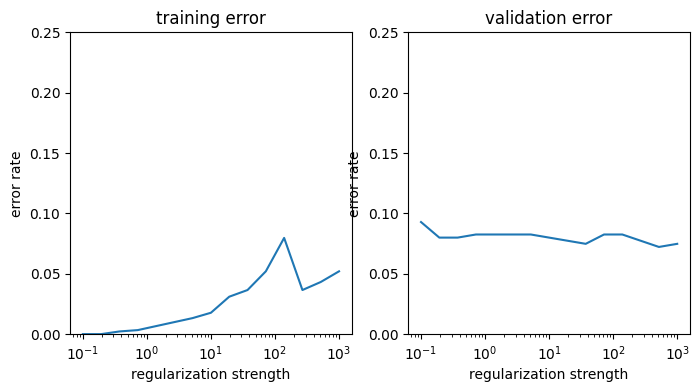

In [130]:
# Do not adjust!
# This will plot the training and validation errors and pick the best value of lambda
# It will retrain on the full training set with that lambda value and store
# the weights in bestw
def errrate(X,Y,w):
    f = addones(X)@w
    return np.mean(Y!=(f>0))

fig,axs = plt.subplots(1,2)

lams = np.logspace(-1,3,15)
trainerr = np.zeros(len(lams))
validerr = np.zeros(len(lams))
for i,l in enumerate(lams):
    w = learnlr(subtrainX,subtrainY,l)
    trainerr[i] = errrate(subtrainX,subtrainY,w)
    validerr[i] = errrate(validX,validY,w)
for ax,e in zip(axs,[trainerr,validerr]):
    ax.semilogx(lams,e)
for i,ax in enumerate(axs):
    ax.set_title('training error' if i==0 else 'validation error')
    ax.set_xlabel('regularization strength')
    ax.set_ylabel('error rate')
    ax.set_ylim(0,0.25)
besti = np.argmin(validerr)
bestw = learnlr(trainX,trainY,lams[besti])
print('best lambda value',lams[besti])

<div class="alert alert-warning">
    <font size=+2>Question 2</font><br>
    <font size=+1>3 points</font>
</div>

<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: /3<br>
</div>

Plot below the ROC curve for the resulting classifier (the weights are saved in `bestw`) on the *testing* data.  Label your plot.  Use `plt.axis('square')` to get a square plot.

You may assume that the raw values returned by the classifier ($w^Tx$) are all unique for the $x$s in the testing set.

(-0.04987804878048781,
 1.0474390243902438,
 -0.04275862068965518,
 1.0545584524810765)

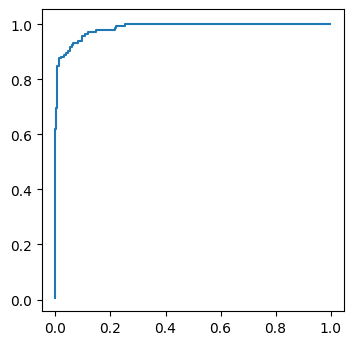

In [131]:
## Your code here
newtestX = addones(testX)
wx = newtestX@bestw

indexs = wx.argsort()
newtestY = np.where(testY==1,1,-1)
wx = wx[indexs[::-1]]
newtestY = newtestY[indexs[::-1]]
thresholds = [ (wx[i]+wx[i+1])/2 for i in range(len(wx)-1) ]
thresholds.insert(0,wx[0]-0.1)
thresholds.append(wx[-1]+0.1)

tprs = []
fprs = []
for threshold in thresholds:
    y_hat = np.where(wx>threshold,1,-1)
    tp = np.sum(np.logical_and(y_hat == 1, newtestY == 1))
    tn = np.sum(np.logical_and(y_hat == -1, newtestY == -1))
    fp = np.sum(np.logical_and(y_hat == 1, newtestY == -1))
    fn = np.sum(np.logical_and(y_hat == -1, newtestY == 1))
    tpr = tp/(tp+fn)
    fpr = fp/(tn+fp)
    tprs.append(tpr)
    fprs.append(fpr)

plt.plot(fprs,tprs)

plt.axis('square')